In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import os
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from scipy.stats import kendalltau

sns.set(font_scale=1.5)
sns.set_style('white')

In [3]:
from pymer4.models import Lmer
from rpy2.robjects.packages import importr

## Functions

In [106]:

def removeOutlierAndScale(df, features,nonZeroFeatures=[]):
    """
    Prepares data specifically for mixed effects models:
    1. Handles outliers (IQR method → set to NaN)
    2. Robust scaling (median/IQR normalization)
    3. Median imputation
    """
    df_clean = df.copy()
    for col in nonZeroFeatures:
        df_clean.loc[df_clean[col]<=0,col]=np.nan
    # 1. Outlier handling: Set to NaN
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Set outliers to NaN
        df_clean.loc[df_clean[col] < lower, col] = np.nan
        df_clean.loc[df_clean[col] > upper, col] = np.nan
    # 2. Robust scaling (feature-wise normalization)
    scaler = RobustScaler()
    df_clean[features] = scaler.fit_transform(df_clean[features])
    # 3. Median imputation for missing values
    #imputer = SimpleImputer(strategy='median')
    #df_clean[features] = imputer.fit_transform(df_clean[features])
    return df_clean
def calculate_r2(model,depvar):
    """Calculate marginal and conditional R² for LMM with (1|ID) structure"""
    # Get model data
    data = model.data
    # Fixed effects prediction
    fixed_pred = model.predict(data, use_rfx=False,verify_predictions=False)
    # Full model prediction
    full_pred = model.predict(data, use_rfx=True,verify_predictions=False)
    # Create mask of non-NaN indices across all relevant vectors
    mask = (
        ~np.isnan(data[depvar]) & 
        ~np.isnan(fixed_pred) & 
        ~np.isnan(full_pred)
    )
    
    # Apply mask to all vectors
    depvar_clean = data[depvar][mask].values
    fixed_pred_clean = np.array(fixed_pred)[mask]
    full_pred_clean = np.array(full_pred)[mask]
    
    # Calculate variances using cleaned data
    var_total = np.var(depvar_clean)
    var_fixed = np.var(fixed_pred_clean)
    var_full = np.var(full_pred_clean)
    # Marginal R² (fixed effects only)
    r2m = var_fixed / var_total
    # Conditional R² (fixed + random effects)
    r2c = var_full / var_total
    return r2m, r2c
def getAddOnStar(p):
    if p<.01:return '**'
    elif p<.05:return '*'
    else: return ''
def calculate_corrwithp(df, xCols=None, yCols=None,method='Pearson'):
    """Returns p-values of correlations"""
    if xCols == None:
        xCols = df.columns
        yCols = xCols
    else:
        if yCols == None:
            yCols = xCols
    pvalues = pd.DataFrame(columns=xCols).transpose().join(pd.DataFrame(columns=yCols), how='outer')
    corr = pvalues.copy()
    for r in xCols:
        for c in yCols:
            if r == c:
                cor, pval = 1, 0
            else:
                tmp = df[[r, c]].dropna()
                if method=='Pearson':
                    cor, pval = stats.pearsonr(tmp[r], tmp[c])
                elif method=='Kendall':
                    cor, pval = stats.kendalltau(tmp[r], tmp[c])
            pvalues.loc[r, c] = pval
            corr.loc[r, c] = cor
    return corr.astype(float).loc[xCols, yCols], pvalues.astype(float).loc[xCols, yCols]
def makeplot(df,targetVar,independentVar,confoundVar,independentLabel):
    modeldata=df[list(set([targetVar,independentVar,confoundVar]))].dropna()
    # Residualize X ~ Z
    model_x = sm.OLS(modeldata[independentVar], sm.add_constant(modeldata[confoundVar]))
    res_x = model_x.fit().resid
    res_df = pd.DataFrame({'res_X': res_x, 'X': modeldata[independentVar], 'Y': modeldata[targetVar]})
    
    kendall_original, p_original = kendalltau(modeldata[targetVar], modeldata[independentVar])
    kendall_adjusted, p_adjusted = kendalltau(res_x, modeldata[targetVar])
    # Step 2: Create the plot
    plt.figure(figsize=(9, 6), dpi=100)
    # Plot original data points (faded)
    sns.scatterplot(x='X', y='Y', data=res_df, alpha=0.35, color='gray', label='Original')
    sns.regplot(
        x='X', 
        y='Y', 
        data=res_df,
        scatter=False,  # We already have the points
        line_kws={'color': 'gray', 'linestyle': '-', 'alpha': 0.5, 'lw': 2.5},
        ci=None
    )
    # Plot residualized relationship
    sns.regplot(
        x='res_X', 
        y='Y', 
        data=res_df,
        scatter_kws={'alpha': 0.7, 'color': 'steelblue'},
        line_kws={'color': 'red', 'lw': 2},
        ci=95,
        label='WordCnt Adjusted'
    )
    sns.despine()
    
    # Add reference lines
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', alpha=0.3)
    
    # Labels and title
    plt.xlabel(independentLabel, fontsize=16)
    plt.ylabel(targetVar, fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Add text annotation for slope
    plt.annotate(f'Original τ = {kendall_original:.2f}{getAddOnStar(p_original)}', 
                 xy=(0.05, 0.8), 
                 xycoords='axes fraction',
                 fontsize=14,
                 color='gray',
                 bbox=dict(boxstyle='round', fc='white', alpha=0.8))
    
    plt.annotate(f'Adjusted τ = {kendall_adjusted:.2f}{getAddOnStar(p_adjusted)}', 
                 xy=(0.05, 0.85), 
                 xycoords='axes fraction',
                 fontsize=14,
                 color='red',
                 bbox=dict(boxstyle='round', fc='white', alpha=0.8))
    plt.tight_layout()
    plt.show()


# Study 1

In [110]:
projectFolder= 'path_to_project'
featureFolder = projectFolder+'path_to_feature/'
dtFolder =  projectFolder+'path_to_rating/'

### DT task

In [112]:
label='rubber'
DT_rubber=pd.read_excel(projectFolder+'/DT/compiled_ratings.xlsx',sheet_name=label)
DT_rubber['task']=label
tmp=pd.read_csv(featureFolder+label+'_perplexity.csv',index_col=None)
tmp.rename(columns={'mean':'perplexMean','std':'perplexStd','vol':'perplexVol','count':'length'},inplace=True)
DT_rubber=DT_rubber.merge(tmp,left_on='ID',right_on='ID',how='outer')
dsiDF=pd.read_csv(projectFolder+'/dsi_output_'+label+'.csv',index_col=None).drop(columns=['Nwords'])
DT_rubber=DT_rubber.merge(dsiDF,how='outer',left_on='ID',right_on='ID')

In [114]:
label='wing'
DT_wing=pd.read_excel(projectFolder+'/DT/compiled_ratings.xlsx',sheet_name=label)
print(len(DT_wing.dropna()))
DT_wing['task']=label
tmp=pd.read_csv(featureFolder+label+'_perplexity.csv',index_col=None)
tmp.rename(columns={'mean':'perplexMean','std':'perplexStd','vol':'perplexVol','count':'length'},inplace=True)
DT_wing=DT_wing.merge(tmp,left_on='ID',right_on='ID',how='outer')

dsiDF=pd.read_csv(projectFolder+'/dsi_output_'+label+'.csv',index_col=None).drop(columns=['Nwords'])
DT_wing=DT_wing.merge(dsiDF,how='outer',left_on='ID',right_on='ID')


83


In [43]:
DT_wing.describe()

,ID,fluency,originality,elaboration,perplexMean,perplexStd,perplexVol,length,DSI
count,88.000000,83.000000,83.000000,83.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,47.636364,8.024096,4.164627,2.330150,3.062336,2.534134,3.484608,682.310345,0.820667
std,27.601508,3.047849,0.684457,0.387262,0.263036,0.181079,0.254689,164.342687,0.006136
min,1.000000,0.666667,1.500000,1.150000,2.466262,2.169097,2.928067,267.000000,0.802430
25%,24.750000,5.833333,3.802652,2.053175,2.884035,2.423592,3.357191,594.500000,0.816900
50%,47.500000,8.000000,4.303896,2.314815,3.044000,2.545012,3.485467,691.000000,0.820708
75%,71.250000,9.833333,4.587714,2.490741,3.194734,2.661207,3.623164,778.000000,0.824824
max,94.000000,19.000000,5.504762,3.350794,3.940932,2.924972,4.284920,1192.000000,0.839667


In [116]:
scaler = RobustScaler()
allfeatures=['originality','elaboration','fluency','perplexMean','length','DSI']

DT_rubber[allfeatures] = scaler.fit_transform(DT_rubber[allfeatures])
DT_wing[allfeatures] = scaler.fit_transform(DT_wing[allfeatures])
dtCombine=pd.concat([DT_rubber,DT_wing])

In [118]:
tmp=dtCombine[['ID','task','perplexMean','length','DSI']]
tmp['othertask']=tmp.apply(lambda r: 'wing' if r['task']=='rubber' else 'rubber',axis=1)
print(len(tmp))
dtCombine=dtCombine.merge(tmp,left_on=['ID','task'],right_on=['ID','othertask'],suffixes=('','_c'),how='left')
dtCombine.describe()

176


/var/folders/f4/kqf7rn397cj8ynryplksbjvm0000gr/T/ipykernel_2905/3813445547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['othertask']=tmp.apply(lambda r: 'wing' if r['task']=='rubber' else 'rubber',axis=1)


,ID,fluency,originality,elaboration,perplexMean,perplexStd,perplexVol,length,DSI,perplexMean_c,length_c,DSI_c
count,176.000000,166.000000,166.000000,166.000000,174.000000,174.000000,174.000000,174.000000,174.000000,164.000000,164.000000,164.000000
mean,47.636364,0.072624,-0.092141,0.128867,0.013853,0.908064,0.864309,-0.036410,-0.010661,0.021982,0.011046,0.022193
std,27.522534,0.822140,0.838573,0.975373,0.829571,0.104320,0.088977,0.825247,0.742763,0.784637,0.780814,0.736439
min,1.000000,-1.833333,-3.571559,-2.662031,-1.856236,0.656214,0.699472,-2.361111,-2.306618,-1.856236,-2.000000,-2.306618
25%,24.750000,-0.486111,-0.615950,-0.414464,-0.540765,0.827034,0.798530,-0.548611,-0.506719,-0.484182,-0.502273,-0.416926
50%,47.500000,0.000000,0.000000,0.000000,0.000000,0.905488,0.861632,0.000000,0.000000,0.001394,0.000000,0.083506
75%,71.250000,0.541667,0.425118,0.567696,0.463224,0.976387,0.917097,0.472727,0.505412,0.461925,0.479545,0.537266
max,94.000000,3.111111,2.757258,4.352476,2.907796,1.161394,1.123845,2.638889,2.392647,2.907796,2.638889,2.392647


### rest think-aloud

In [120]:
perplexDF=pd.read_csv(featureFolder+'ta_perplexity.csv',index_col=None)
perplexDF.rename(columns={'mean':'perplexMean','std':'perplexStd','vol':'perplexVol','count':'length'},inplace=True)
dsiDF=pd.read_csv(projectFolder+'/dsi_output.csv',index_col=None).drop(columns=['Nwords'])
perplexDF=perplexDF.merge(dsiDF,how='outer',left_on='ID',right_on='ID')
perplexDF.describe()

,ID,perplexMean,perplexStd,perplexVol,length,DSI
count,88.000000,87.000000,87.000000,87.000000,87.000000,88.000000
mean,48.965909,2.903677,0.944701,0.882894,313.160920,0.819930
std,26.578640,0.255300,0.096391,0.078407,103.656619,0.006094
min,1.000000,2.304265,0.604407,0.636699,91.000000,0.804521
25%,27.750000,2.722966,0.885441,0.836206,247.000000,0.816795
50%,50.500000,2.865745,0.924339,0.874906,310.000000,0.820017
75%,71.250000,3.035869,0.997173,0.927732,380.000000,0.824210
max,94.000000,3.754115,1.235879,1.108267,565.000000,0.836517


In [122]:
scaler = RobustScaler()
allfeatures=['perplexMean','length','DSI']
perplexDF[allfeatures] = scaler.fit_transform(perplexDF[allfeatures])

dtCombine=dtCombine.merge(perplexDF,left_on=['ID'],right_on=['ID'],suffixes=('','_r'),how='outer')


In [53]:
dtCombine[dtCombine.isna().any(axis=1)]

,ID,fluency,originality,elaboration,task,session,perplexMean,perplexStd,perplexVol,length,...,task_c,perplexMean_c,length_c,DSI_c,othertask,perplexMean_r,perplexStd_r,perplexVol_r,length_r,DSI_r
0,1,1.222222,0.292773,0.098233,rubber,NaN,NaN,NaN,NaN,NaN,...,wing,1.491763,0.081744,0.182174,rubber,0.239028,2.345892,3.343720,0.452972,-0.474307
1,1,-0.416667,-0.541014,1.845224,wing,rawWings,1.491763,2.679117,3.630770,0.081744,...,rubber,NaN,NaN,NaN,wing,0.239028,2.345892,3.343720,0.452972,-0.474307
2,2,-0.222222,2.757258,3.536387,rubber,rawRubber,-0.439397,2.557234,3.368424,1.310345,...,wing,-0.232331,2.730245,0.954003,rubber,NaN,NaN,NaN,NaN,NaN
3,2,0.750000,0.558442,-0.010418,wing,rawWings,-0.232331,2.648006,3.414937,2.730245,...,rubber,-0.439397,1.310345,0.475032,wing,NaN,NaN,NaN,NaN,NaN
4,3,-0.444444,-0.800494,-0.906766,rubber,rawRubber,-0.466973,2.508624,3.310133,-0.722323,...,wing,NaN,NaN,NaN,rubber,NaN,NaN,NaN,NaN,NaN
5,3,-0.666667,-1.801909,-0.757557,wing,NaN,NaN,NaN,NaN,NaN,...,rubber,-0.466973,-0.722323,-0.143385,wing,NaN,NaN,NaN,NaN,NaN
18,10,1.222222,1.210624,-0.749593,rubber,rawRubber,1.085978,2.674754,3.642277,0.482759,...,wing,0.649602,0.354223,-0.029223,rubber,NaN,NaN,NaN,NaN,0.565372
19,10,2.750000,0.886088,-0.788440,wing,rawWings,0.649602,2.546834,3.666557,0.354223,...,rubber,1.085978,0.482759,1.239045,wing,NaN,NaN,NaN,NaN,0.565372
24,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.447728,2.481352,3.306389,0.487585,-0.431863
43,24,-0.111111,0.340951,-0.253894,rubber,rawRubber,1.311307,2.758340,3.750529,0.000000,...,wing,0.765443,0.005450,0.881100,rubber,NaN,NaN,NaN,NaN,NaN


In [29]:
corr,p=calculate_corrwithp(dtCombine,xCols=['length','perplexMean','DSI'],method='Kendall')
np.round(corr,3)

,length,perplexMean,DSI
length,1.000,-0.021,0.111
perplexMean,-0.021,1.000,0.363
DSI,0.111,0.363,1.000


In [610]:
np.round(p,3)

,length,perplexMean,DSI
length,0.000,0.681,0.028
perplexMean,0.681,0.000,0.000
DSI,0.028,0.000,0.000


In [612]:
corr,p=calculate_corrwithp(dtCombine,xCols=['length_r','perplexMean_r','DSI_r'],method='Kendall')
np.round(corr,3)

,length_r,perplexMean_r,DSI_r
length_r,1.000,-0.22,0.074
perplexMean_r,-0.220,1.00,0.370
DSI_r,0.074,0.37,1.000


In [614]:
np.round(p,3)

,length_r,perplexMean_r,DSI_r
length_r,0.000,0.0,0.154
perplexMean_r,0.000,0.0,0.000
DSI_r,0.154,0.0,0.000


## Mixed Effect Model

In [31]:
for depvar in ['originality','elaboration','fluency']:
    tmp=dtCombine[[depvar,'perplexMean','length','ID','task','DSI']].dropna()
    print(depvar+' Model:')

    model = Lmer(formula=f"{depvar} ~ perplexMean+length +(1|ID)+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')

    model = Lmer(formula=f"{depvar} ~ DSI+length +(1|ID)+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n\n\n')

originality Model:


/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: originality~perplexMean+length+(1|ID)+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'ID': 83.0, 'task': 2.0}

Log-likelihood: -205.613 	 AIC: 423.225

Random effects:

                 Name    Var    Std
ID        (Intercept)  0.017  0.131
task      (Intercept)  0.001  0.037
Residual               0.613  0.783

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    -0.077  -0.208    0.055  0.067    1.078  -1.140  0.447     
perplexMean     0.317   0.161    0.473  0.080  124.007   3.981  0.000  ***
length          0.161   0.006    0.317  0.079   93.748   2.040  0.044    *
Marginal R2: 0.10132968016005219, Conditional R2: 0.10502503918893051

Linear mixed model fit by REML [’lmerMod’]
Formula: originality~DSI+length+(1|ID)+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Gr

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~perplexMean+length+(1|ID)+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'ID': 83.0, 'task': 2.0}

Log-likelihood: -231.286 	 AIC: 474.573

Random effects:

                 Name    Var    Std
ID        (Intercept)  0.098  0.313
task      (Intercept)  0.002  0.045
Residual               0.766  0.875

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.131  -0.030    0.292  0.082    1.427   1.598  0.297     
perplexMean     0.103  -0.084    0.290  0.095  122.112   1.084  0.281     
length          0.375   0.187    0.564  0.096   88.159   3.902  0.000  ***
Marginal R2: 0.09446889352742228, Conditional R2: 0.11208208221241338

Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~DSI+length+(1|ID)+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Gr

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [622]:
#cross trial, perplex predict originality
for depvar in ['originality','elaboration','fluency']:
    tmp=dtCombine[[depvar,'perplexMean_c','length_c','ID','task','DSI_c']].dropna()
    print(depvar+' Model:')

    model = Lmer(formula=f"{depvar} ~ perplexMean_c+length_c+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')

    model = Lmer(formula=f"{depvar} ~ DSI_c+length_c+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')

    print('\n\n')

originality Model:


/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: originality~perplexMean_c+length_c+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'task': 2.0}

Log-likelihood: -205.149 	 AIC: 420.297

Random effects:

                 Name    Var    Std
task      (Intercept)  0.011  0.106
Residual               0.623  0.789

No random effect correlations specified

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)      -0.075  -0.264    0.114  0.096    0.998  -0.776  0.580     
perplexMean_c     0.317   0.163    0.471  0.078  166.003   4.039  0.000  ***
length_c          0.247   0.095    0.400  0.078  166.354   3.183  0.002   **
Marginal R2: 0.12516087156314687, Conditional R2: 0.1282886228622309

Linear mixed model fit by REML [’lmerMod’]
Formula: originality~DSI_c+length_c+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'task': 2.0}

Log-likelihood: -210.307 	

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~perplexMean_c+length_c+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'task': 2.0}

Log-likelihood: -232.410 	 AIC: 474.819

Random effects:

                 Name    Var    Std
task      (Intercept)  0.020  0.140
Residual               0.863  0.929

No random effect correlations specified

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val Sig
(Intercept)       0.124  -0.115    0.362  0.122    0.998   1.015  0.495    
perplexMean_c    -0.098  -0.279    0.083  0.092  166.003  -1.065  0.289    
length_c          0.280   0.101    0.459  0.091  166.312   3.062  0.003  **
Marginal R2: 0.06295820775434291, Conditional R2: 0.06787286987700226

Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~DSI_c+length_c+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 170	 Groups: {'task': 2.0}

Log-likelihood: -231.108 	 AI

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [624]:
#rest, perplex predict originality
for depvar in ['originality','elaboration','fluency']:   
    tmp = dtCombine[[depvar,'perplexMean_r','length_r','task','DSI_r']].dropna()
    print(depvar+' Model:')

    model = Lmer(formula=f"{depvar} ~ perplexMean_r+length_r+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')

    
    model = Lmer(formula=f"{depvar} ~ DSI_r+length_r+(1|task)",
                data=tmp)
    model.fit(summary=False)
    print(model.summary())
    r2m,r2c = calculate_r2(model,depvar)
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')
    
    print('\n\n')

originality Model:
Linear mixed model fit by REML [’lmerMod’]
Formula: originality~perplexMean_r+length_r+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 162	 Groups: {'task': 2.0}

Log-likelihood: -196.834 	 AIC: 403.667

Random effects:

                 Name    Var    Std
task      (Intercept)  0.003  0.059
Residual               0.636  0.797

No random effect correlations specified

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val Sig
(Intercept)      -0.139  -0.291    0.013  0.078    1.124  -1.791  0.303    
perplexMean_r     0.094  -0.074    0.263  0.086  158.000   1.097  0.274    
length_r          0.184   0.001    0.366  0.093  158.000   1.976  0.050   *
Marginal R2: 0.024288468067843044, Conditional R2: 0.02512200776153852



/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: originality~DSI_r+length_r+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 162	 Groups: {'task': 2.0}

Log-likelihood: -197.401 	 AIC: 404.802

Random effects:

                 Name    Var    Std
task      (Intercept)  0.003  0.059
Residual               0.640  0.800

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val Sig
(Intercept)    -0.122  -0.270    0.027  0.076    1.022  -1.608  0.350    
DSI_r           0.034  -0.126    0.194  0.082  158.000   0.418  0.676    
length_r        0.138  -0.026    0.303  0.084  158.000   1.652  0.101    
Marginal R2: 0.018005735440559195, Conditional R2: 0.018815023617531415




elaboration Model:
Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~perplexMean_r+length_r+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 162	 Groups: {'task': 2.0}

Log-likelihoo

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: elaboration~DSI_r+length_r+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 162	 Groups: {'task': 2.0}

Log-likelihood: -220.537 	 AIC: 451.074

Random effects:

                 Name    Var    Std
task      (Intercept)  0.001  0.023
Residual               0.858  0.926

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val Sig
(Intercept)     0.115  -0.032    0.262  0.075    1.03   1.531  0.363    
DSI_r          -0.024  -0.209    0.161  0.094  158.00  -0.254  0.800    
length_r        0.276   0.086    0.466  0.097  158.00   2.843  0.005  **
Marginal R2: 0.04862583326093734, Conditional R2: 0.04863948301500396




fluency Model:
Linear mixed model fit by REML [’lmerMod’]
Formula: fluency~perplexMean_r+length_r+(1|task)

Family: gaussian	 Inference: parametric

Number of observations: 162	 Groups: {'task': 2.0}

Log-likelihood: -188.016 	 

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


## Visualize Univariate Correlation

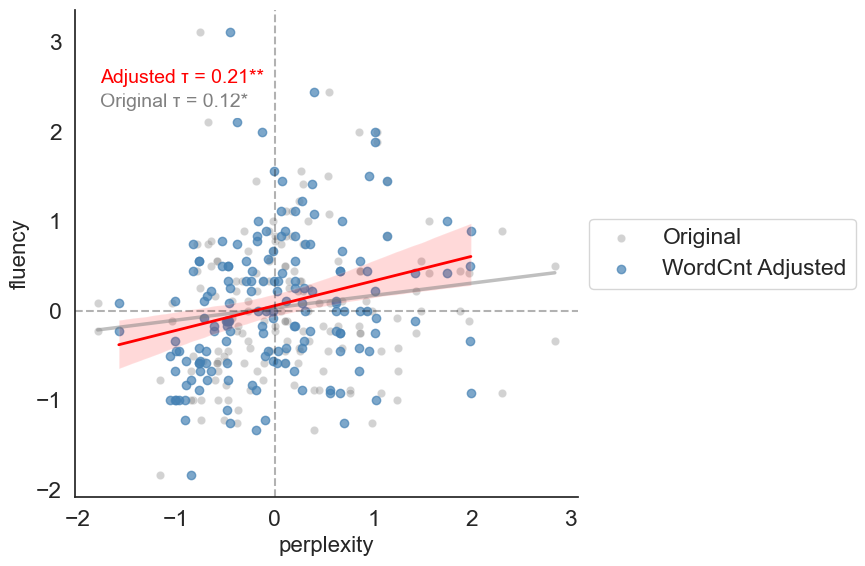

In [124]:
target='fluency'
independent = 'perplexMean_r'
confound_i='length_r'

makeplot(dtCombine,target,independent,confound_i,'perplexity')

# Study 2

In [64]:
projectFolder= 'path_to_project'

In [98]:
folder_path = projectFolder+'path_to_perplexity/'
all_files = [f for f in os.listdir(folder_path if f.endswith('.csv')]  #the whole data set was processed in batch for perplexity, so recombining here
alldata=[pd.read_csv(os.path.join(folder_path, f)) for f in all_files]
df = pd.concat(alldata,ignore_index=True)
df=df[['FacScoresO','ProblemID','wordcount','DSI','perplexity']].rename(columns={'FacScoresO':'originality'})
df.head()

/var/folders/f4/kqf7rn397cj8ynryplksbjvm0000gr/T/ipykernel_2905/1847793929.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(alldata,ignore_index=True)


,originality,ProblemID,wordcount,DSI,perplexity
0,-0.209286,Ralph,23,0.779919,3.193717
1,-0.209286,Ralph,33,0.787905,2.937871
2,-0.519868,Ralph,21,0.780913,3.263944
3,-0.827342,Ralph,20,0.785918,2.526872
4,-0.827342,Ralph,10,0.712558,2.567013


In [100]:
df = removeOutlierAndScale(df, ['originality','wordcount','perplexity','DSI'])
df.describe()


,originality,wordcount,DSI,perplexity
count,3197.000000,3111.000000,3067.000000,3087.000000
mean,0.085547,0.128424,-0.082440,0.057278
std,0.719016,0.721024,0.754117,0.764625
min,-1.547878,-1.026316,-2.321472,-1.965158
25%,-0.484170,-0.447368,-0.523863,-0.475972
50%,0.000000,0.000000,0.000000,0.000000
75%,0.515830,0.552632,0.476137,0.524028
max,2.057908,2.263158,1.945431,2.158460


In [102]:
modeldata=df[['originality','wordcount','DSI','perplexity','ProblemID']].dropna()
    
for var in ['DSI', 'perplexity']:
    model = Lmer(formula=f"originality ~ wordcount+{var} +(1|ProblemID)",
            data=modeldata)
    model.fit(summary=False)
    print(model.summary())
    r2m, r2c = calculate_r2(model,'originality')
    print(f'Marginal R2: {r2m}, Conditional R2: {r2c}\n')

    print('\n\n')

/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: originality~wordcount+DSI+(1|ProblemID)

Family: gaussian	 Inference: parametric

Number of observations: 2823	 Groups: {'ProblemID': 6.0}

Log-likelihood: -2695.362 	 AIC: 5400.724

Random effects:

                  Name    Var    Std
ProblemID  (Intercept)  0.006  0.075
Residual                0.392  0.626

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.094   0.027    0.161  0.034     4.996   2.756   0.04    *
wordcount       0.276   0.236    0.317  0.021  2775.796  13.369   0.00  ***
DSI             0.167   0.128    0.206  0.020  2711.977   8.338   0.00  ***
Marginal R2: 0.16671201001133498, Conditional R2: 0.1629770655320135




Linear mixed model fit by REML [’lmerMod’]
Formula: originality~wordcount+perplexity+(1|ProblemID)

Family: gaussian	 Inference: parametric

Number of observations: 2823	 Groups: {'ProblemID': 6.0}

Log

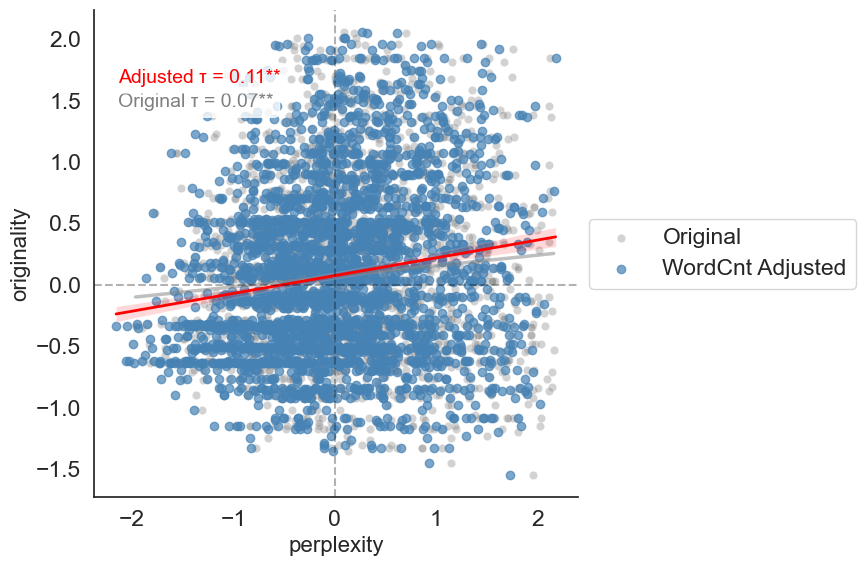

In [108]:
target='originality'
independent = 'perplexity'
confound_i='wordcount'

makeplot(df,target,independent,confound_i,'perplexity')